In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add, Dense, AveragePooling2D, Flatten
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# Cargar datos
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

BATCH_SIZE = 100
AUTO = tf.data.AUTOTUNE

In [ ]:
# Función de preprocesamiento
def preprocess(image, label):
    # Convertir y normalizar
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = preprocess_input(image)
    label = tf.cast(label, tf.int32)
    return image, label

In [ ]:
# Conjunto de datos de entrenamiento
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = (
    train_ds
    .map(preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Conjunto de datos de prueba
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = (
    test_ds
    .map(preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)


# Entrenar el modelo
history = model.fit(train_ds, validation_data=test_ds, epochs=10)

# Visualizar las curvas de aprendizaje
#plt.plot(history.history['accuracy'], label='Training Accuracy')
#plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#plt.title('Curvas de Aprendizaje')
#plt.xlabel('Época')
#plt.ylabel('Precisión')
#plt.legend()
#plt.show()

In [ ]:
# Función de preprocesamiento
def preprocess(image, label):
    # Convertir y normalizar
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = preprocess_input(image)
    label = tf.cast(label, tf.int32)
    return image, label

In [ ]:
# Conjunto de datos de entrenamiento
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = (
    train_ds
    .shuffle(1024)
    .map(preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Aplicar aumento de datos al conjunto de entrenamiento
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    # Agrega más transformaciones según sea necesario
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                        num_parallel_calls=AUTO)

In [ ]:
# Modelo base DenseNet121 preentrenado
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
base_model.trainable = True  # Congelar capas preentrenadas

# Agregar capas adicionales para adaptarse a la tarea de clasificación
x = base_model.output

# Comprobar dimensiones espaciales para aplicar AveragePooling2D
if x.shape[1] >= 2 and x.shape[2] >= 2:
    x = AveragePooling2D(pool_size=(2, 2))(x)
else:
    x = Flatten()(x)

x = Dense(256, activation='relu')(x)
predictions = Dense(100, activation='softmax')(x)

In [ ]:
# Modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo con una tasa de aprendizaje ajustada
model.compile(optimizer=Adam(learning_rate=0.0001), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])


1/1 [==============================] - 0s 408ms/step


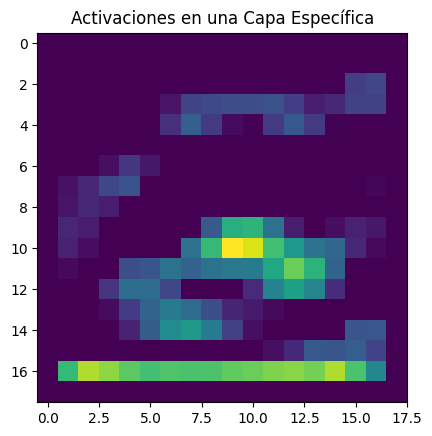

In [ ]:
from tensorflow.keras.models import Model

# Crear un modelo intermedio que devuelva las activaciones de ciertas capas
activation_model = Model(inputs=model.input, outputs=model.layers[5].output)

# Obtener activaciones para una muestra de datos
sample_image = x_train[0].reshape((1,) + x_train[0].shape)
activations = activation_model.predict(sample_image)

# Visualizar las activaciones
plt.imshow(activations[0, :, :, 0], cmap='viridis')
plt.title('Activaciones en una Capa Específica')
plt.show()


In [ ]:
# Evaluar el modelo
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
